
Average word count: 511.98

Average vocabulary size: 176.84
[43, 28, 25, 22, 19, 24, 53, 21, 31, 5, 27, 15, 11, 9, 1, 26, 23, 31, 21, 16, 19, 15, 9, 26, 24, 18, 12, 45, 14, 11, 11, 17, 14, 10, 22, 22, 20, 18, 16, 14, 8, 21, 15, 7, 37, 17, 14, 12, 7, 24, 8, 20, 6, 22, 19, 20, 4, 43, 16, 12, 12, 41, 42, 19, 39, 68, 17, 21, 4, 22, 9, 17, 11, 49, 26, 35, 17, 15, 24, 24, 23, 28, 20, 8, 6, 24, 35, 20, 29, 29, 10, 11, 24, 13, 25, 3, 15, 15, 20, 44, 20, 33, 27, 33, 28, 24, 42, 24, 20, 38, 33, 21, 30, 16, 26, 41, 47, 17, 17, 19, 11, 10, 19, 36, 20, 22, 9, 20, 10, 9, 38, 28, 16, 28, 37, 40, 15, 35, 32, 26, 21, 41, 51, 30, 30, 39, 39, 26, 11, 7, 33, 41, 19, 2, 5, 29, 20, 17, 14, 34, 10, 8, 22, 5, 32, 2, 6, 5, 40, 12, 7, 18, 17, 15, 19, 16, 18, 26, 16, 45, 24, 28, 19, 25, 41, 21, 19, 36, 27, 29, 15, 31, 14, 35, 21, 31, 28, 18, 29, 1, 50, 22, 11, 16, 27, 38, 24, 34, 20, 17, 49, 32, 28, 26, 16, 12, 25, 32, 24, 13, 14, 18, 22, 11, 21, 22, 31, 8, 11, 23, 20, 31, 14, 15, 21, 8, 20, 24, 23, 14, 11, 2, 

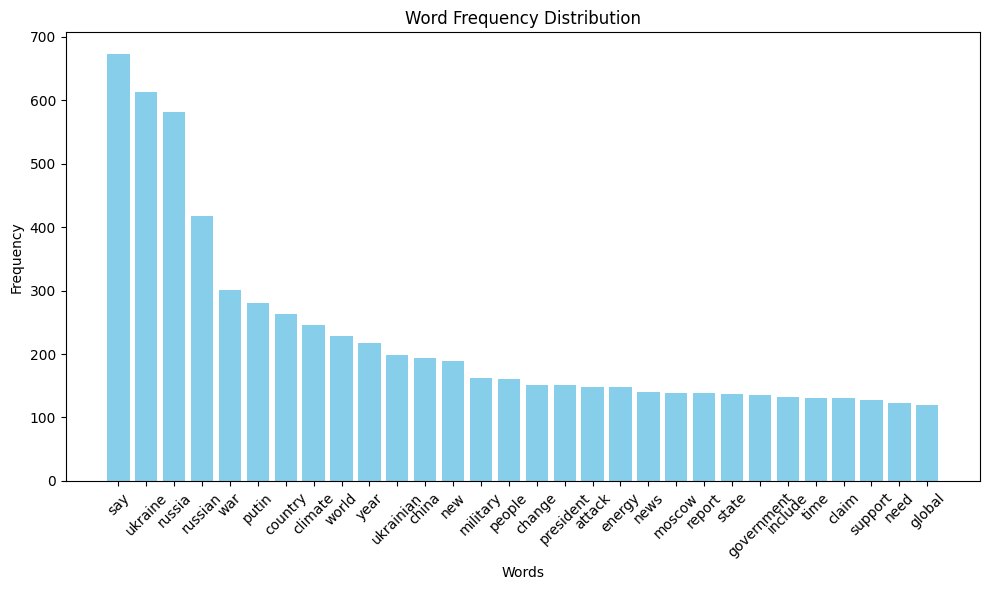

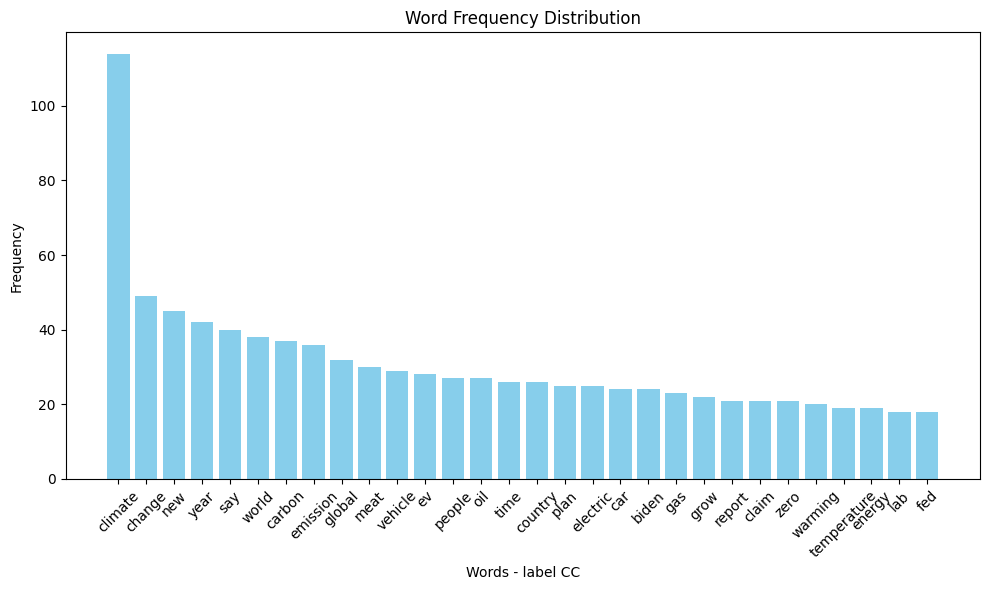

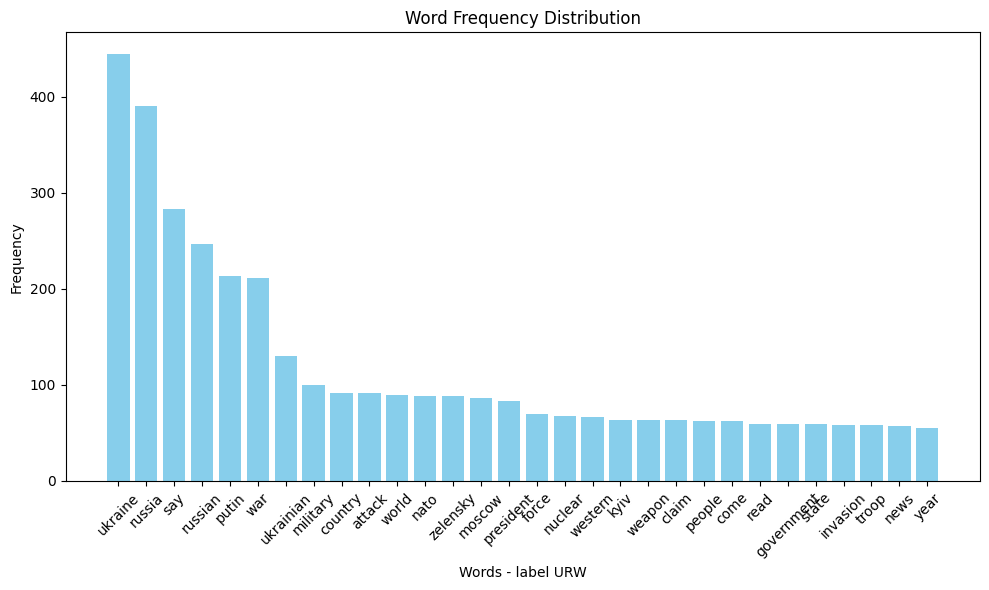

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter



'Analyze English Texts'

folder_path = "training_data_16_October_release/EN/raw-documents/"

nlp = spacy.load("en_core_web_md")

def count_sentence_length(doc):
    sentence_lengths = []
    for sentence in doc.sents:
        sentence_length = len([token.text for token in sentence if not token.is_punct])
        sentence_lengths.append(sentence_length)
    return sentence_lengths

def word_count_vocabulary_size(doc):
    word_count = 0
    unique_tokens = set()
    token_freq = Counter()
    for token in doc:
        if not token.is_punct and not token.is_space:
            word_count+=1
            if not token.is_stop and token.is_alpha:
                unique_tokens.add(token.lemma_.lower())
                token_freq[token.lemma_.lower()] += 1

    return word_count, unique_tokens, token_freq


def process_labels(line):
    file_name, label_category_part = line.split('\t', 1)  # Split by tab to get file name and label-category part
    labels = []
    categories = []

    if label_category_part == "Other	Other":
        labels.append("Other")
        categories.append("Other")
        return file_name, labels, categories
    
    # Split the label-category part by semicolons
    label_category_pairs = label_category_part.split(';')
    
    # Extract labels and categories from each pair
    for pair in label_category_pairs:
        if ':' in pair:
            label, category = pair.split(':', 1)
            labels.append(label.strip())
            categories.append(category.strip())
    
    return file_name, labels, categories

# read labels
all_file_names = []
all_labels = []
all_categories = []

with open("training_data_16_October_release/EN/subtask-2-annotations.txt", 'r', encoding='utf-8') as file:
    for line in file:
        file_name, labels, categories = process_labels(line.strip())  # Process each line
        
        # Store the results
        all_file_names.extend([file_name] * len(labels))  # Repeat the file name for each label
        all_labels.extend(labels)
        all_categories.extend(categories)

# Create a DataFrame from the collected data
df = pd.DataFrame({
    'File Name': all_file_names,
    'Label': all_labels,
    'Category': all_categories
})

# Display the DataFrame
#print(df.head)

word_counts = []
vocabulary_sizes=[]
shortest_article=100000
longest_article=0
token_freq_all = Counter()
token_freq_URW = Counter()
token_freq_CC = Counter()
sentence_lengths = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    # Only process .txt files
    if filename.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        doc= nlp(text)
        
        word_count, unique_tokens, token_freq =word_count_vocabulary_size(doc)
        if shortest_article>word_count:
            shortest_article=word_count
        if longest_article < word_count:
            longest_article=word_count
        word_counts.append(word_count)
        vocabulary_sizes.append(len(unique_tokens))
        matching_row = df[df['File Name'] == filename]
        label = matching_row['Label'].iloc[0]
        if label=="CC":
            token_freq_CC.update(token_freq)
        elif label == "URW":
            token_freq_URW.update(token_freq)
        token_freq_all.update(token_freq)
        sentence_lengths_one_document = count_sentence_length(doc)
        sentence_lengths.extend(sentence_lengths_one_document)


#calculate average word count
if word_counts:  
    average_word_count = sum(word_counts) / len(word_counts)
    print(f"\nAverage word count: {average_word_count:.2f}")

#calculate average vocabulary size - lemmatized
if vocabulary_sizes:  
    average_vocabulary_size = sum(vocabulary_sizes) / len(vocabulary_sizes)
    print(f"\nAverage vocabulary size: {average_vocabulary_size:.2f}")

#calculate average sentence length
if sentence_lengths:
    average_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
    print(f"\nAverage sentence length: {average_sentence_length:.2f}")


print(f"\nThe shortest article: {shortest_article:.2f}")
print(f"\nThe longest article: {longest_article:.2f}")


# frequency distribution
top_n = 30
most_common_words = token_freq_all.most_common(top_n)
words, frequencies = zip(*most_common_words) 

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(words, frequencies, color='skyblue')  # Bar plot
plt.xlabel('Words')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Word Frequency Distribution')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# frequency distribution - label CC
most_common_words = token_freq_CC.most_common(top_n)
words, frequencies = zip(*most_common_words) 

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(words, frequencies, color='skyblue')  # Bar plot
plt.xlabel('Words - label CC')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Word Frequency Distribution')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# frequency distribution - label URW
most_common_words = token_freq_URW.most_common(top_n)
words, frequencies = zip(*most_common_words) 

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(words, frequencies, color='skyblue')  # Bar plot
plt.xlabel('Words - label URW')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Word Frequency Distribution')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()





    

  